In [59]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable

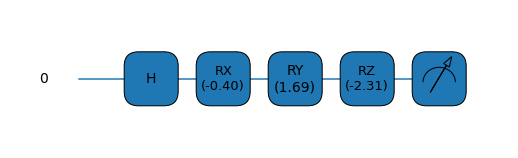

In [60]:
device = qml.device('qiskit.aer', wires=3, backend='qasm_simulator')
params = np.random.normal(0,np.pi/2, 3)
params = Variable(torch.tensor(params), requires_grad=True)

@qml.qnode(device, interface="torch")
def circuit(params, M=None):
    qml.Hadamard(wires=0)
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=0)
    qml.RZ(params[2], wires=0)
    
    return qml.expval(qml.Hermitian(M, wires=[0]))
fig, ax = qml.draw_mpl(circuit, decimals=2)(params)
plt.show()

In [61]:
import random
a = random.random()
b = (1-a**2)**0.5
target_state = np.array([a, b])
target_op = np.outer(target_state.conj(), target_state)
target_op = torch.tensor(target_op)
print(target_state)
print(target_op)

[0.34863955 0.93725688]
tensor([[0.1215, 0.3268],
        [0.3268, 0.8785]], dtype=torch.float64)


In [62]:
def cost(params):
    L = (1-(circuit(params, M=target_op)))**2
    return L

In [63]:
opt = torch.optim.Adam([params], lr=0.1)
best_loss = 1*cost(params)
best_params = 1*params

In [96]:
fidelity=[]
epochs=[]
for epoch in range(25):
    opt.zero_grad()
    loss = cost(params)
    print(epoch, loss.item())
    loss.backward()
    opt.step()
    if loss < best_loss:
        best_loss = 1*loss
        best_params = 1*params
    f = circuit(best_params, M=target_op).item()
    epochs.append(epoch)
    fidelity.append(f)

0 6.103515625e-05
1 9.5367431640625e-05
2 0.00011539459228515625
3 9.5367431640625e-05
4 8.58306884765625e-06
5 4.673004150390625e-05
6 0.00011539459228515625
7 2.384185791015625e-05
8 8.58306884765625e-06
9 8.58306884765625e-06
10 3.4332275390625e-05
11 9.5367431640625e-07
12 9.5367431640625e-07
13 9.5367431640625e-07
14 9.5367431640625e-07
15 0.0
16 0.0
17 0.0
18 0.0
19 0.0
20 0.0
21 0.0
22 3.814697265625e-06
23 0.0
24 0.0


In [65]:
print(circuit(best_params, M=target_op).item())

0.9990234375


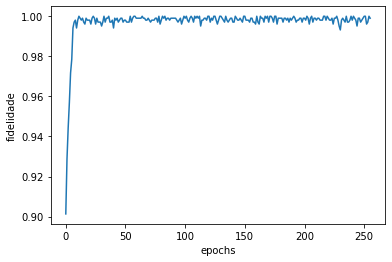

In [66]:
plt.plot(epochs, fidelity)
plt.xlabel('epochs')
plt.ylabel('fidelidade')
plt.show()

Para estados puros, a fidelidade é igual ao quadrado do valor esperado.

valor esperado pode ser calculado diretamente do VQA.

In [107]:
def fidelidade(target_op):
    return circuit(best_params, M=target_op).item()
def init_state_params():
    params = np.random.normal(0,np.pi/2, 3)
    params = Variable(torch.tensor(params), requires_grad=True)
    a = random.random()
    b = (1-a**2)**0.5
    target_state = np.array([a, b])
    target_op = np.outer(target_state.conj(), target_state)
    target_op = torch.tensor(target_op)
    return target_op, params

@qml.qnode(device, interface="torch")
def circuit(params, M=None):
    qml.Hadamard(wires=0)
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=0)
    qml.RZ(params[2], wires=0)
    
    return qml.expval(qml.Hermitian(M, wires=[0]))

def cost(params,target_op):
    L = (1-(circuit(params, M=target_op)))**2
    return L

def train(params,target_op):
    opt = torch.optim.Adam([params], lr=0.1)
    best_loss = 1*cost(params,target_op)
    best_params = 1*params
    for epoch in range(32):
        opt.zero_grad()
        loss = cost(params,target_op)
        print(epoch, loss.item())
        loss.backward()
        opt.step()
        if loss < best_loss:
            best_loss = 1*loss
            best_params = 1*params
    return best_params, best_loss


In [109]:
fidelidade_media=0
for i in range(100):
    target_op, params = init_state_params()
    best_params, best_loss = train(params,target_op)
    fidelidade_media += fidelidade(target_op)**2
fidelidade_media = fidelidade_media/100
print(fidelidade_media)

0 0.001377105712890625
1 0.00042057037353515625
2 3.4332275390625e-05
3 2.384185791015625e-05
4 3.814697265625e-06
5 4.673004150390625e-05
6 6.103515625e-05
7 6.103515625e-05
8 0.0001373291015625
9 0.00011539459228515625
10 0.00021457672119140625
11 9.5367431640625e-05
12 1.52587890625e-05
13 6.103515625e-05
14 1.52587890625e-05
15 8.58306884765625e-06
16 0.0
17 9.5367431640625e-07
18 8.58306884765625e-06
19 0.0
20 3.814697265625e-06
21 0.0
22 0.0
23 8.58306884765625e-06
24 3.814697265625e-06
0 0.005802154541015625
1 0.0033197402954101562
2 0.001102447509765625
3 0.0009164810180664062
4 0.000186920166015625
5 7.724761962890625e-05
6 2.384185791015625e-05
7 1.52587890625e-05
8 9.5367431640625e-07
9 0.0
10 1.52587890625e-05
11 2.384185791015625e-05
12 7.724761962890625e-05
13 0.000186920166015625
14 7.724761962890625e-05
15 0.000244140625
16 0.000244140625
17 0.00011539459228515625
18 0.000308990478515625
19 0.00021457672119140625
20 0.0003814697265625
21 0.00011539459228515625
22 0.0001

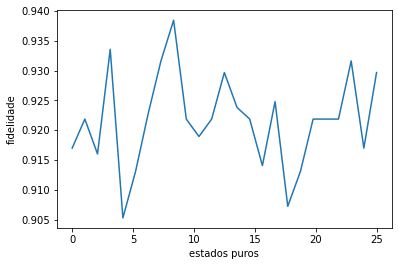

In [112]:
x=np.linspace(0,len(fidelity),len(fidelity))
plt.plot(x, fidelity)
plt.xlabel('estados puros')
plt.ylabel('fidelidade')
plt.show()